### High level Summary of the Notebook

This notebook provides a walk-through of various figures realted to the Multiple Instance Learning (MIL) workflow used in the study. It begins by loading the configuration file, which includes all relevant variables, the outputs of the MIL approach, the intra-trabecular space level polygon annotations, the score assigned to each of those region by the MIL model. 

The notebook then presents an evaluation of the MIL model. It first visualizes the AUROC distribution to give an overview of model performance. This is followed by plots showing the rank assigned to each sample within the disease trajectory.

Next, it highlights the spatiotypes that drive that strongly drive the prediction score helps in identifying spatial patterns driving the ST micro score. Finally, it inter and intra sample hetrogenity in terms of score driving features and within sample hetrogeneity. Even within cases belongs to same disease grou (MF) different features are likely driving the prediction score. This visualization helps reveal the diversity of predictive drivers within similar diagnostic groups.

Lastly, the notebook show correlation between fibrosis score from a H&E based model and ST score. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
from shapely import wkt

import os
import sys
sys.path.append('../../../')
from configuration import STConfig
from utils.misc import environ_feats
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler


### Initializing Configuration Object

In [2]:
cfg = STConfig()
itr_df = pd.read_csv(cfg.pth_its_score_file)
itr_df.head(3)

,Unnamed: 0,it_id,score,label,fold_idx,Endothelial-0,Endothelial-1,Endothelial-2,Erythroid-0,Erythroid-1,...,Megakaryocyte-2,Myeloid-0,Myeloid-1,Myeloid-2,Stromal-0,Stromal-1,Stromal-2,Osteo-MSC-0,Osteo-MSC-1,Osteo-MSC-2
0,0,18256_R1_R1,0.08253,1,0,0.000009,-0.00027,0.000096,-0.247337,0.000018,...,0.000004,0.00245,0.032032,-0.000026,0.000029,-0.000143,0.061528,-0.000023,0.000003,0.000015
1,1,18256_R1_R1,0.08253,1,0,0.000009,-0.00027,0.000096,-0.247337,0.000018,...,0.000004,0.00245,0.032032,-0.000026,0.000029,-0.000143,0.061528,-0.000023,0.000003,0.000015
2,2,18256_R1_R1,0.08253,1,0,0.000009,-0.00027,0.000096,-0.247337,0.000018,...,0.000004,0.00245,0.032032,-0.000026,0.000029,-0.000143,0.061528,-0.000023,0.000003,0.000015


### Loading sample level and ITS level score predicted by the MIL model

In [3]:
skey,dkey= 'sample_key', 'diagnosis2'
sampleDf = pd.read_csv(cfg.pth_sample_level_score_file)
sampleDf.head(3)

,sample_key,diagnosis2,scores,labels,fold_idx
0,10693_R2,PV,-1.080295,1.0,0
1,10693_R1,MF,0.578704,1.0,0
2,16832_R1,MF,-0.458804,1.0,0


In [4]:
sampleRunDf = pd.read_csv(cfg.pth_bootstrap_score_file)
sampleRunDf.rename(columns={'Unnamed: 0':skey}, inplace=True)
mapping = sampleDf.set_index(skey)[dkey].to_dict() # copying diagnosis info to rundf file
sampleRunDf[dkey] = sampleRunDf[skey].map(mapping)
sampleRunDf.head(3)

,sample_key,scores,labels,fold_idx,diagnosis2
0,10693_R1,1.088714,1.0,0,MF
1,16832_R1,-0.051433,1.0,0,MF
2,18286_R1,0.171172,1.0,0,MF


### Predictive Performance of MIL model in classifying Normal vs MF cases in terms of AUROC

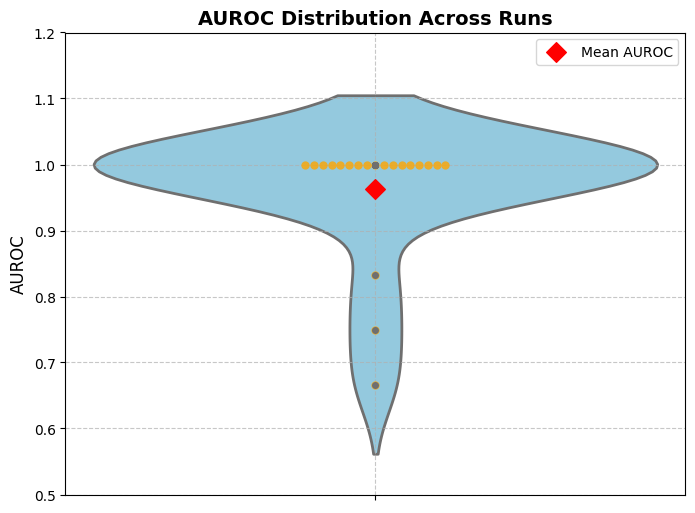

In [5]:
nmDf = sampleRunDf[sampleRunDf[dkey].isin(['Normal', 'MF'])]
# Compute AUROC for each bootstrap run using fold_idx
auroc_scores = []
for fold, group in nmDf.groupby('fold_idx'):
    auc = roc_auc_score(group['labels'], group['scores'])
    auroc_scores.append(auc)

plt.figure(figsize=(8, 6))
sns.swarmplot(data=auroc_scores, color='orange', size=6, alpha=0.8)
sns.violinplot(data=auroc_scores, inner='point', color='skyblue', linewidth=2)
plt.scatter(0, np.mean(auroc_scores), color='red', s=100, marker='D', label='Mean AUROC', zorder=5)
plt.title('AUROC Distribution Across Runs', fontsize=14, fontweight='bold')
plt.ylabel('AUROC', fontsize=12)
plt.ylim(0.5, 1.2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.show()

In [6]:
from statsmodels.stats.api import DescrStatsW
desc_stats = DescrStatsW(auroc_scores)

# 95% confidence interval
ci_lower, ci_upper = desc_stats.tconfint_mean()

# Summary statistics
summary_stats = {
    'Mean AUROC': desc_stats.mean,
    '95% CI Lower': ci_lower,
    '95% CI Upper': ci_upper
}

summary_df = pd.DataFrame([summary_stats])
summary_df

,Mean AUROC,95% CI Lower,95% CI Upper
0,0.9625,0.917807,1.007193


#### Below we sort sample based on the ranking assigned by the MIL model

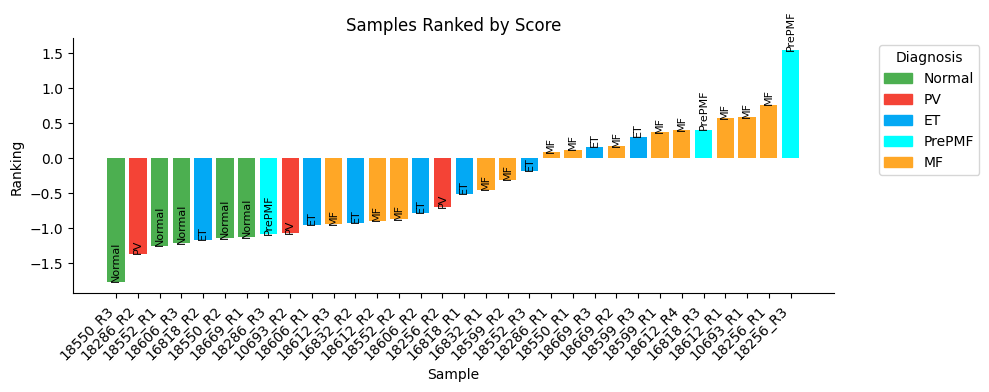

In [7]:
df_sorted = sampleDf.sort_values("scores", ascending=True)

# 2. Map each diagnosis to a color (optional, but nice)
diagnoses = df_sorted[dkey].unique()
color_map = {
    "Normal": "#4CAF50",   # green
    "ET":     "#03A9F4",   # blue
    "PV":     "#F44336",   # red
    "MF":     "#FFA726",   # orange
    "PrePMF": 'cyan'
}
bar_colors = df_sorted[dkey].map(color_map)

# 3. Make bar plot
plt.figure(figsize=(10, 4))
bars = plt.bar(df_sorted["sample_key"], df_sorted["scores"], color=bar_colors)

# 4. Add diagnosis as text label above each bar
for bar, diag in zip(bars, df_sorted[dkey]):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        diag,
        ha="center",
        va="bottom",
        fontsize=8,
        rotation=90,
    )

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False) 
plt.xlabel("Sample")
plt.ylabel("Ranking")
plt.title("Samples Ranked by Score")
plt.xticks(rotation=45, ha="right")

# Optional: legend for diagnoses
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[d]) for d in diagnoses]
plt.legend(handles, diagnoses, title="Diagnosis", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

### Cohort Level representive features driving the prediction

Violin shown in red and likely increase the overall ST micro score while those shown in blue are reducing the overall score

In [8]:
K = 12 # show top 12 features

# Getting a single value per ITS across multiple runs
itr_df_avg = itr_df.groupby('it_id')[environ_feats].mean()

# features with high mean value
sorted_features = itr_df_avg[environ_feats].mean().sort_values(ascending=False).index.tolist()
topk_pos = sorted_features[0:K]
topk_neg = sorted_features[-K:]

# sorting by variance
topk_pos = itr_df_avg[topk_pos].var().sort_values(ascending=False).index.tolist()
topk_neg = itr_df_avg[topk_neg].var().sort_values(ascending=True).index.tolist()

selected_features = topk_pos+topk_neg

df_long = itr_df_avg[selected_features].melt(
    var_name="Feature", value_name="Value"
)

selected_features_mean = itr_df_avg[selected_features].mean()
# Define group (example: positive vs Low mean sign)
df_long["Group"] = df_long["Feature"].map(
    lambda f: "High" if selected_features_mean[f] > 0 else "Low"
)

df_long.head(3)

,Feature,Value,Group
0,MNP-0,0.802369,High
1,MNP-0,1.161752,High
2,MNP-0,1.012665,High


/tmp/ipykernel_2811/1726023468.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


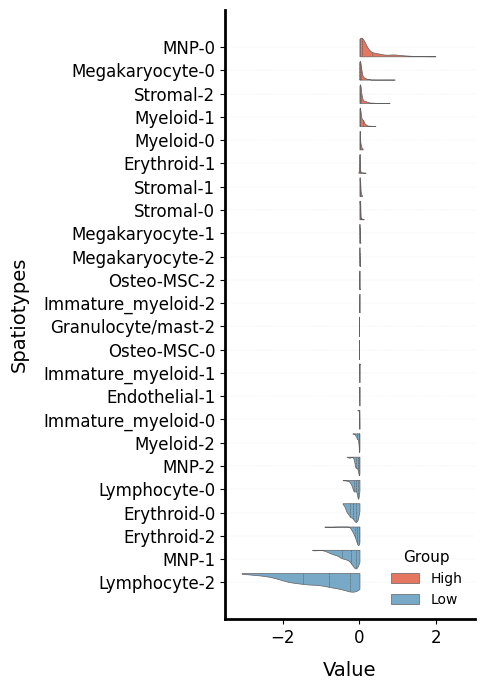

In [9]:
plt.figure(figsize=(5, 7))

light_red = sns.color_palette("Reds", n_colors=3)[1]   # softer red
light_blue = sns.color_palette("Blues", n_colors=3)[1] # softer blue

ax = sns.violinplot(
    data=df_long,
    x="Value", y="Feature",
    hue="Group",
    split=True,             
    inner="quartile",        # show quartile lines inside
    cut=0,                   # don’t extend tails beyond data
    scale="width",
    palette={"High": light_red, "Low": light_blue},
    linewidth=0.5
)

plt.xlim(-3.5, 3)
plt.xlabel("Value", fontsize=14, labelpad=10)
plt.ylabel("Spatiotypes", fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.legend(
    loc="lower right",       
    frameon=False,         
    fontsize=10,
    title="Group",         
    title_fontsize=11
)

# horizontal grid line
for i in range(len(selected_features)):
    ax.hlines(y=i, xmin=-3.7, xmax=3,
              color="gray", linestyle="--", linewidth=0.1, alpha=0.5)


sns.despine(top=True, right=True)
plt.tight_layout()

### Heatmap showing inter- and intr- sample hetrogenity 

In [10]:
from utils.utils_geom import align_sample_polygons
itr_df = pd.read_csv(cfg.pth_its_score_file, index_col=None)
itr_df = itr_df.groupby('it_id', as_index=False).mean().loc[:, ['it_id']+ ['score'] + environ_feats]
itr_df[skey] = itr_df['it_id'].str[:8]
itr_df[dkey] = itr_df[skey].map(mapping)
itr_df.head(2)

,it_id,score,Endothelial-0,Endothelial-1,Endothelial-2,Erythroid-0,Erythroid-1,Erythroid-2,Granulocyte/mast-0,Granulocyte/mast-1,...,Myeloid-1,Myeloid-2,Stromal-0,Stromal-1,Stromal-2,Osteo-MSC-0,Osteo-MSC-1,Osteo-MSC-2,sample_key,diagnosis2
0,10693_R1_R0,0.764334,0.0,-0.000466,0.000093,-0.105917,0.0,0.0,0.000013,0.0,...,0.094128,-0.002012,0.000000,0.026052,0.208610,-0.000003,0.0,0.002113,10693_R1,MF
1,10693_R1_R1,1.066652,0.0,-0.000696,0.000069,-0.202303,0.0,0.0,0.000012,0.0,...,0.094104,-0.000935,0.001084,0.023517,0.164611,-0.000003,0.0,0.000982,10693_R1,MF


In [11]:
itsPoly = pd.read_csv(cfg.pth_its_poly, index_col = 'Unnamed: 0')
itsPoly.head(2)

,geometry
10693_R2_R0,POLYGON ((14233.223529411765 3129.458823529412...
10693_R2_R1,POLYGON ((7484.094117647059 4052.5176470588235...


In [12]:
def plot_heatmaps(df, features_list, disease_group, verbose=False):

    fig, axes = plt.subplots(1, len(features_list), figsize=(22, 7))
    axes = axes.flatten()
    for idx, feat in enumerate(features_list):

        # setting cohort level global max and min
        global_vmin = np.percentile(df[feat], 1)
        global_vmax = np.percentile(df[feat], 99)
        # clipping value between top 1 and bottom 1 percentile

        if verbose:
            print(f'Before scaling global min {global_vmin}, gloabl max {global_vmax}')

        norm = mpl.colors.Normalize(vmin=global_vmin, vmax=global_vmax)

        if verbose:
            print(f'After scaling global min {norm(global_vmin)}, gloabl max {norm(global_vmax)}')

        data = df[~df[dkey].isin(['PrePMF'])]

        data['geometry'] = data['geometry'].apply(wkt.loads)
        group_aligned = align_sample_polygons(data)
        
        ax = axes[idx]
        for _, row in group_aligned.iterrows():
            # Extract the polygon coordinates
            x, y = row['geometry_aligned'].exterior.xy
            # Use the score for coloring (adjust normalization as needed)
            ax.fill(x, y, color=plt.cm.seismic(norm(row[feat])))

        ax.set_title(f'{feat} - {disease_group}')
        ax.set_aspect('equal')
        ax.axis('off')
    plt.tight_layout()
    fig.show()

/tmp/ipykernel_2811/70526331.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_2811/70526331.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


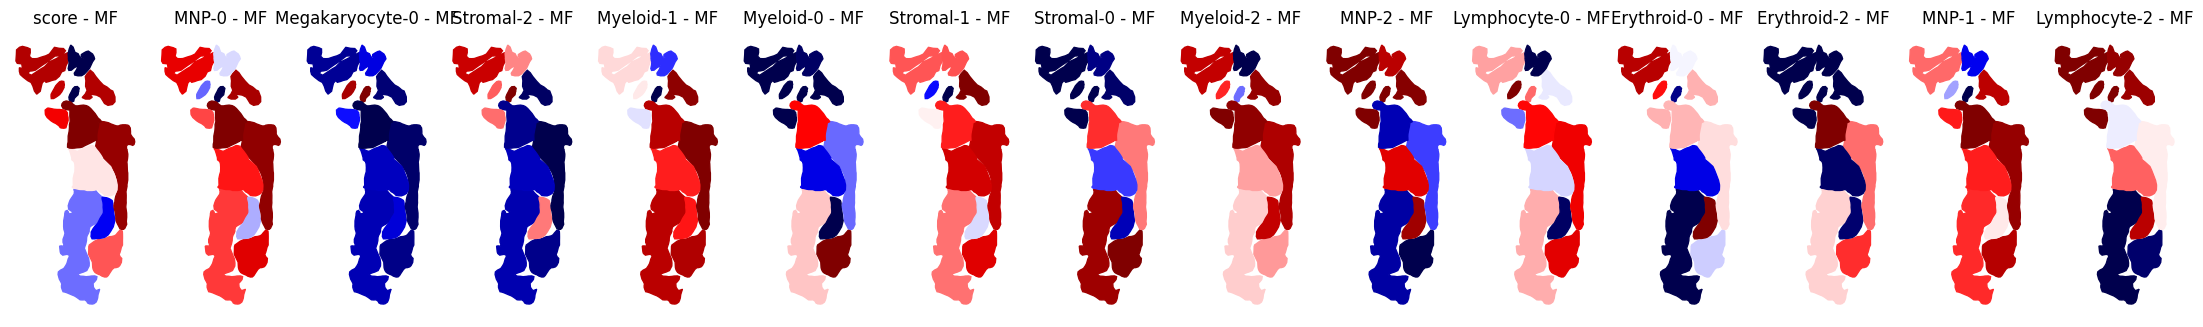

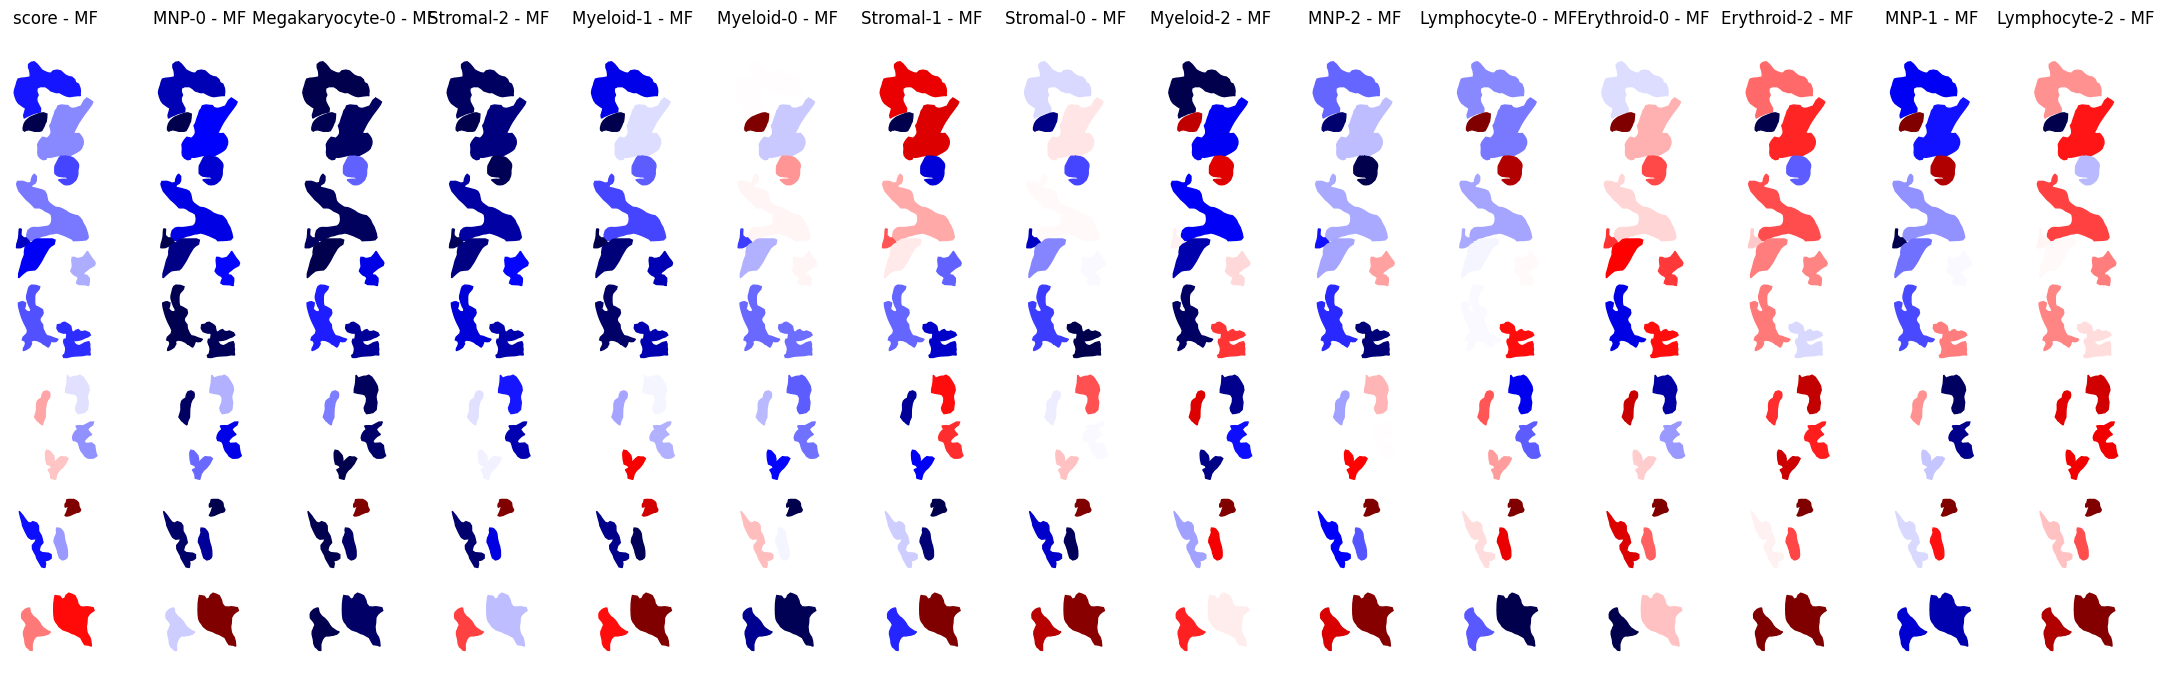

In [13]:
features_list = ['score']+['MNP-0', 'Megakaryocyte-0', 'Stromal-2', 'Myeloid-1', 'Myeloid-0', 'Stromal-1', 'Stromal-0', 'Myeloid-2', 'MNP-2', 'Lymphocyte-0', 'Erythroid-0', 'Erythroid-2', 'MNP-1', 'Lymphocyte-2']
data = itr_df.set_index('it_id').join(itsPoly)

samples = ['18256_R1', '18550_R1']
for sample_key in samples:
    s_df = data[data[skey] ==sample_key]
    plot_heatmaps(s_df,features_list,'MF')
    

### Association between CIF score and ST Score

In [14]:
cif_df = pd.read_csv(cfg.pth_cif_score_file, index_col='Unnamed: 0')
cif_df.head(3)

,geometry,cell_geometry,index_right,X,Y,Score,tile_geometry
aaadmkdg-1_10693_R2,POINT (2257.380098488308 35779.3790026913),POLYGON ((2227.0000861672793 35751.00183823529...,10693_R2_59904_11776,59904.0,11776.0,0.140843,"POLYGON ((2233.307177433693 35886.75539604763,..."
aaaeckml-1_10693_R2,POINT (2239.7945799034583 35729.19159677144),POLYGON ((2239.0000287224266 35698.00091911765...,10693_R2_59904_11776,59904.0,11776.0,0.140843,"POLYGON ((2233.307177433693 35886.75539604763,..."
aaaeejig-1_10693_R2,POINT (2441.5392022267574 35811.60090783731),POLYGON ((2438.000057444853 35796.001838235294...,10693_R2_59904_11776,59904.0,11776.0,0.140843,"POLYGON ((2233.307177433693 35886.75539604763,..."


In [15]:
cell_df = pd.read_csv(cfg.pth_cell_annotations_final, index_col='Unnamed: 0')
cell_df.head(3)

/tmp/ipykernel_2811/1643310486.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_df = pd.read_csv(cfg.pth_cell_annotations_final, index_col='Unnamed: 0')


,region,slide,cell_id,area,cell_status,meg_phenotype,annotation,it_regions,mutation_status,run,...,obj.anno_3_w_megs,obj.anno_4_w_megs,obj.anno_5_w_megs,extra_new_cell_status,sR_cell_refined,obj.anno_1_w_megs_w_stromal,obj.anno_2_w_megs_w_stromal,obj.anno_3_w_megs_w_stromal,obj.anno_4_w_megs_w_stromal,obj.anno_5_w_megs_w_stromal
aaabbbkl-1_10693_R2,new_cell_boundaries,morphology_focus,aaabbbkl-1_10693_R2,11591.402473,original,non_meg,keep,14.0,JAK2,Run1,...,DC,MNP,MNP,original,NaN,DC,DC,DC,MNP,MNP
aaabpmkp-1_10693_R2,new_cell_boundaries,morphology_focus,aaabpmkp-1_10693_R2,12974.009823,original,non_meg,keep,14.0,JAK2,Run1,...,Erythroid,Erythroid,Erythroid,original,NaN,Erythroid,Erythroid,Erythroid,Erythroid,Erythroid
aaabpmmk-1_10693_R2,new_cell_boundaries,morphology_focus,aaabpmmk-1_10693_R2,1247.499138,original,non_meg,keep,14.0,JAK2,Run1,...,Myeloid,Myeloid,Myeloid,original,NaN,Myeloid,Myeloid,Myeloid,Myeloid,Myeloid


In [16]:
cell_df[skey] = cell_df.index.str.split('_').str[-2:].str.join('_')
cell_cif_df = cif_df.join(cell_df.loc[:, ['it_regions']]).loc[:, ['Score', 'it_regions']]
cell_cif_df = cell_cif_df[cell_cif_df['it_regions']!='non_intertrabecular']
its_ids = []
for key in cell_cif_df.index:
    sample_key = '_'.join(key.split('_')[-2:])
    its_id = f'{sample_key}_R{int(float(cell_cif_df.loc[key, "it_regions"]))}'
    its_ids.append(its_id)

cell_cif_df['it_id'] = its_ids
cell_cif_df.head(3)

,Score,it_regions,it_id
aaadmkdg-1_10693_R2,0.140843,14.0,10693_R2_R14
aaaeckml-1_10693_R2,0.140843,14.0,10693_R2_R14
aaaeejig-1_10693_R2,0.140843,14.0,10693_R2_R14


In [17]:
itr_ST_score_df = (
    itr_df.groupby('it_id')['score']
    .mean()
    .reset_index()
    .rename(columns={'score': 'mean_ST_Score'})
)

itr_CIF_score_df = (
    cell_cif_df.groupby('it_id')['Score']
    .mean()
    .reset_index()
    .rename(columns={'Score': 'mean_CIF_Score'})
)

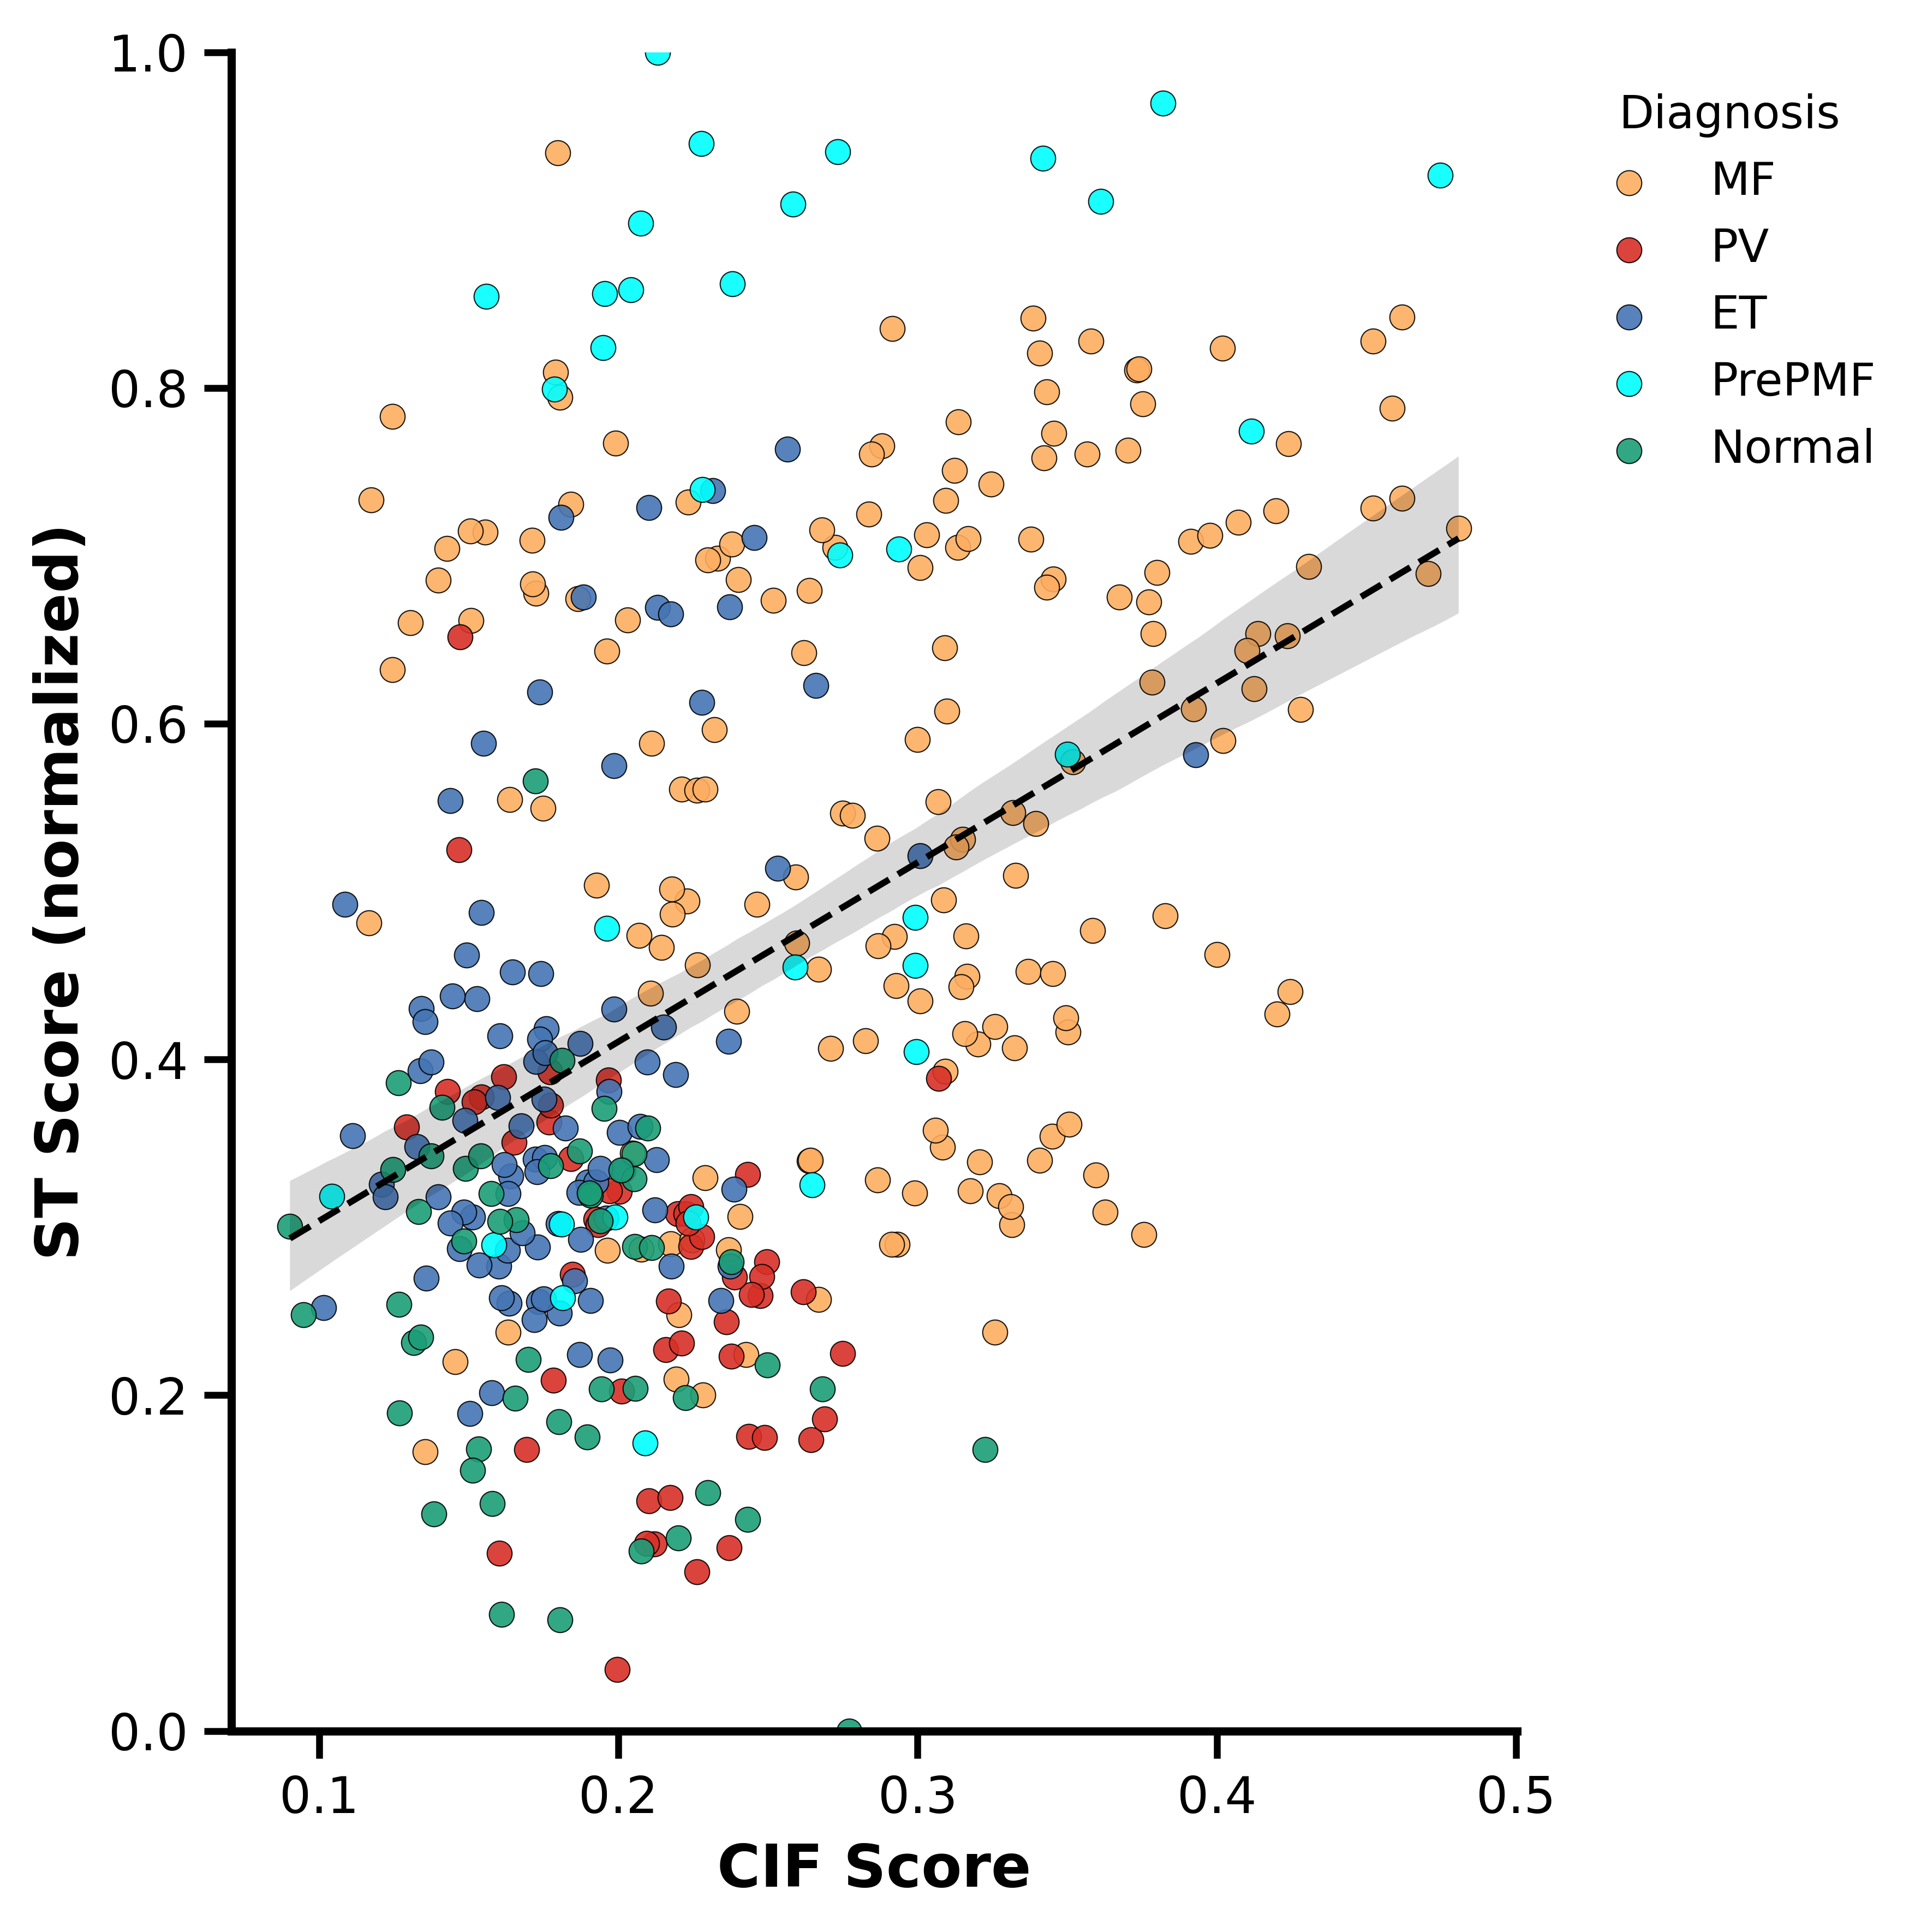

In [18]:
plot_df = itr_CIF_score_df.merge(itr_ST_score_df)
plot_df['mean_ST_Score_norm'] = MinMaxScaler().fit_transform(plot_df[['mean_ST_Score']])

dkey = 'diagnosis2'
xcol = 'mean_CIF_Score'
ycol = 'mean_ST_Score_norm'

mapping = cell_df.loc[:, [skey, dkey]].drop_duplicates()
plot_df[skey] = ['_'.join(idx.split('_')[:-1]) for idx in plot_df['it_id']]
df = plot_df.merge(mapping, on = skey)

## Colormap 
custom_palette = {
    'Normal': '#1b9e77',  # Green
    'PV': '#d73027',      # Red
    'MF': '#fdae61',      # Orange
    'ET': '#4575b4'       # Blue
}

# Using Gray for PrePMF
unique_d = df[dkey].astype(str).unique()
palette = {k: custom_palette.get(k, 'cyan') for k in unique_d}



plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans'],
    'axes.linewidth': 1.8,
    'axes.labelsize': 13,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10
})

fig, ax = plt.subplots(figsize=(6, 6), dpi=600)

for dk in unique_d:
    color = palette[dk]
    sub_d = df[df[dkey].astype(str) == dk]
    ax.scatter(
        sub_d[xcol],
        sub_d[ycol],
        color=color,
        marker='o',    
        s=30,
        alpha=0.9,
        edgecolor='k',
        linewidth=0.25,
        label=dk
    )

sns.regplot(
    data=df,
    x=xcol,
    y=ycol,
    scatter=False,
    color='black',
    line_kws={'linestyle': '--', 'linewidth': 1.4},
    ax=ax
)

ax.set_ylim(0, 1)

ax.set_xlabel("CIF Score", fontsize=13, weight='semibold')
ax.set_ylabel("ST Score (normalized)", fontsize=13, weight='semibold')

# Tick and spine styling
ax.tick_params(axis='both', which='major', width=1.5, length=6)
ax.tick_params(axis='both', which='minor', width=1.2, length=4)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(1.8)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.legend(title="Diagnosis", frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1.0))
sns.despine(top=True, right=True)
plt.tight_layout()


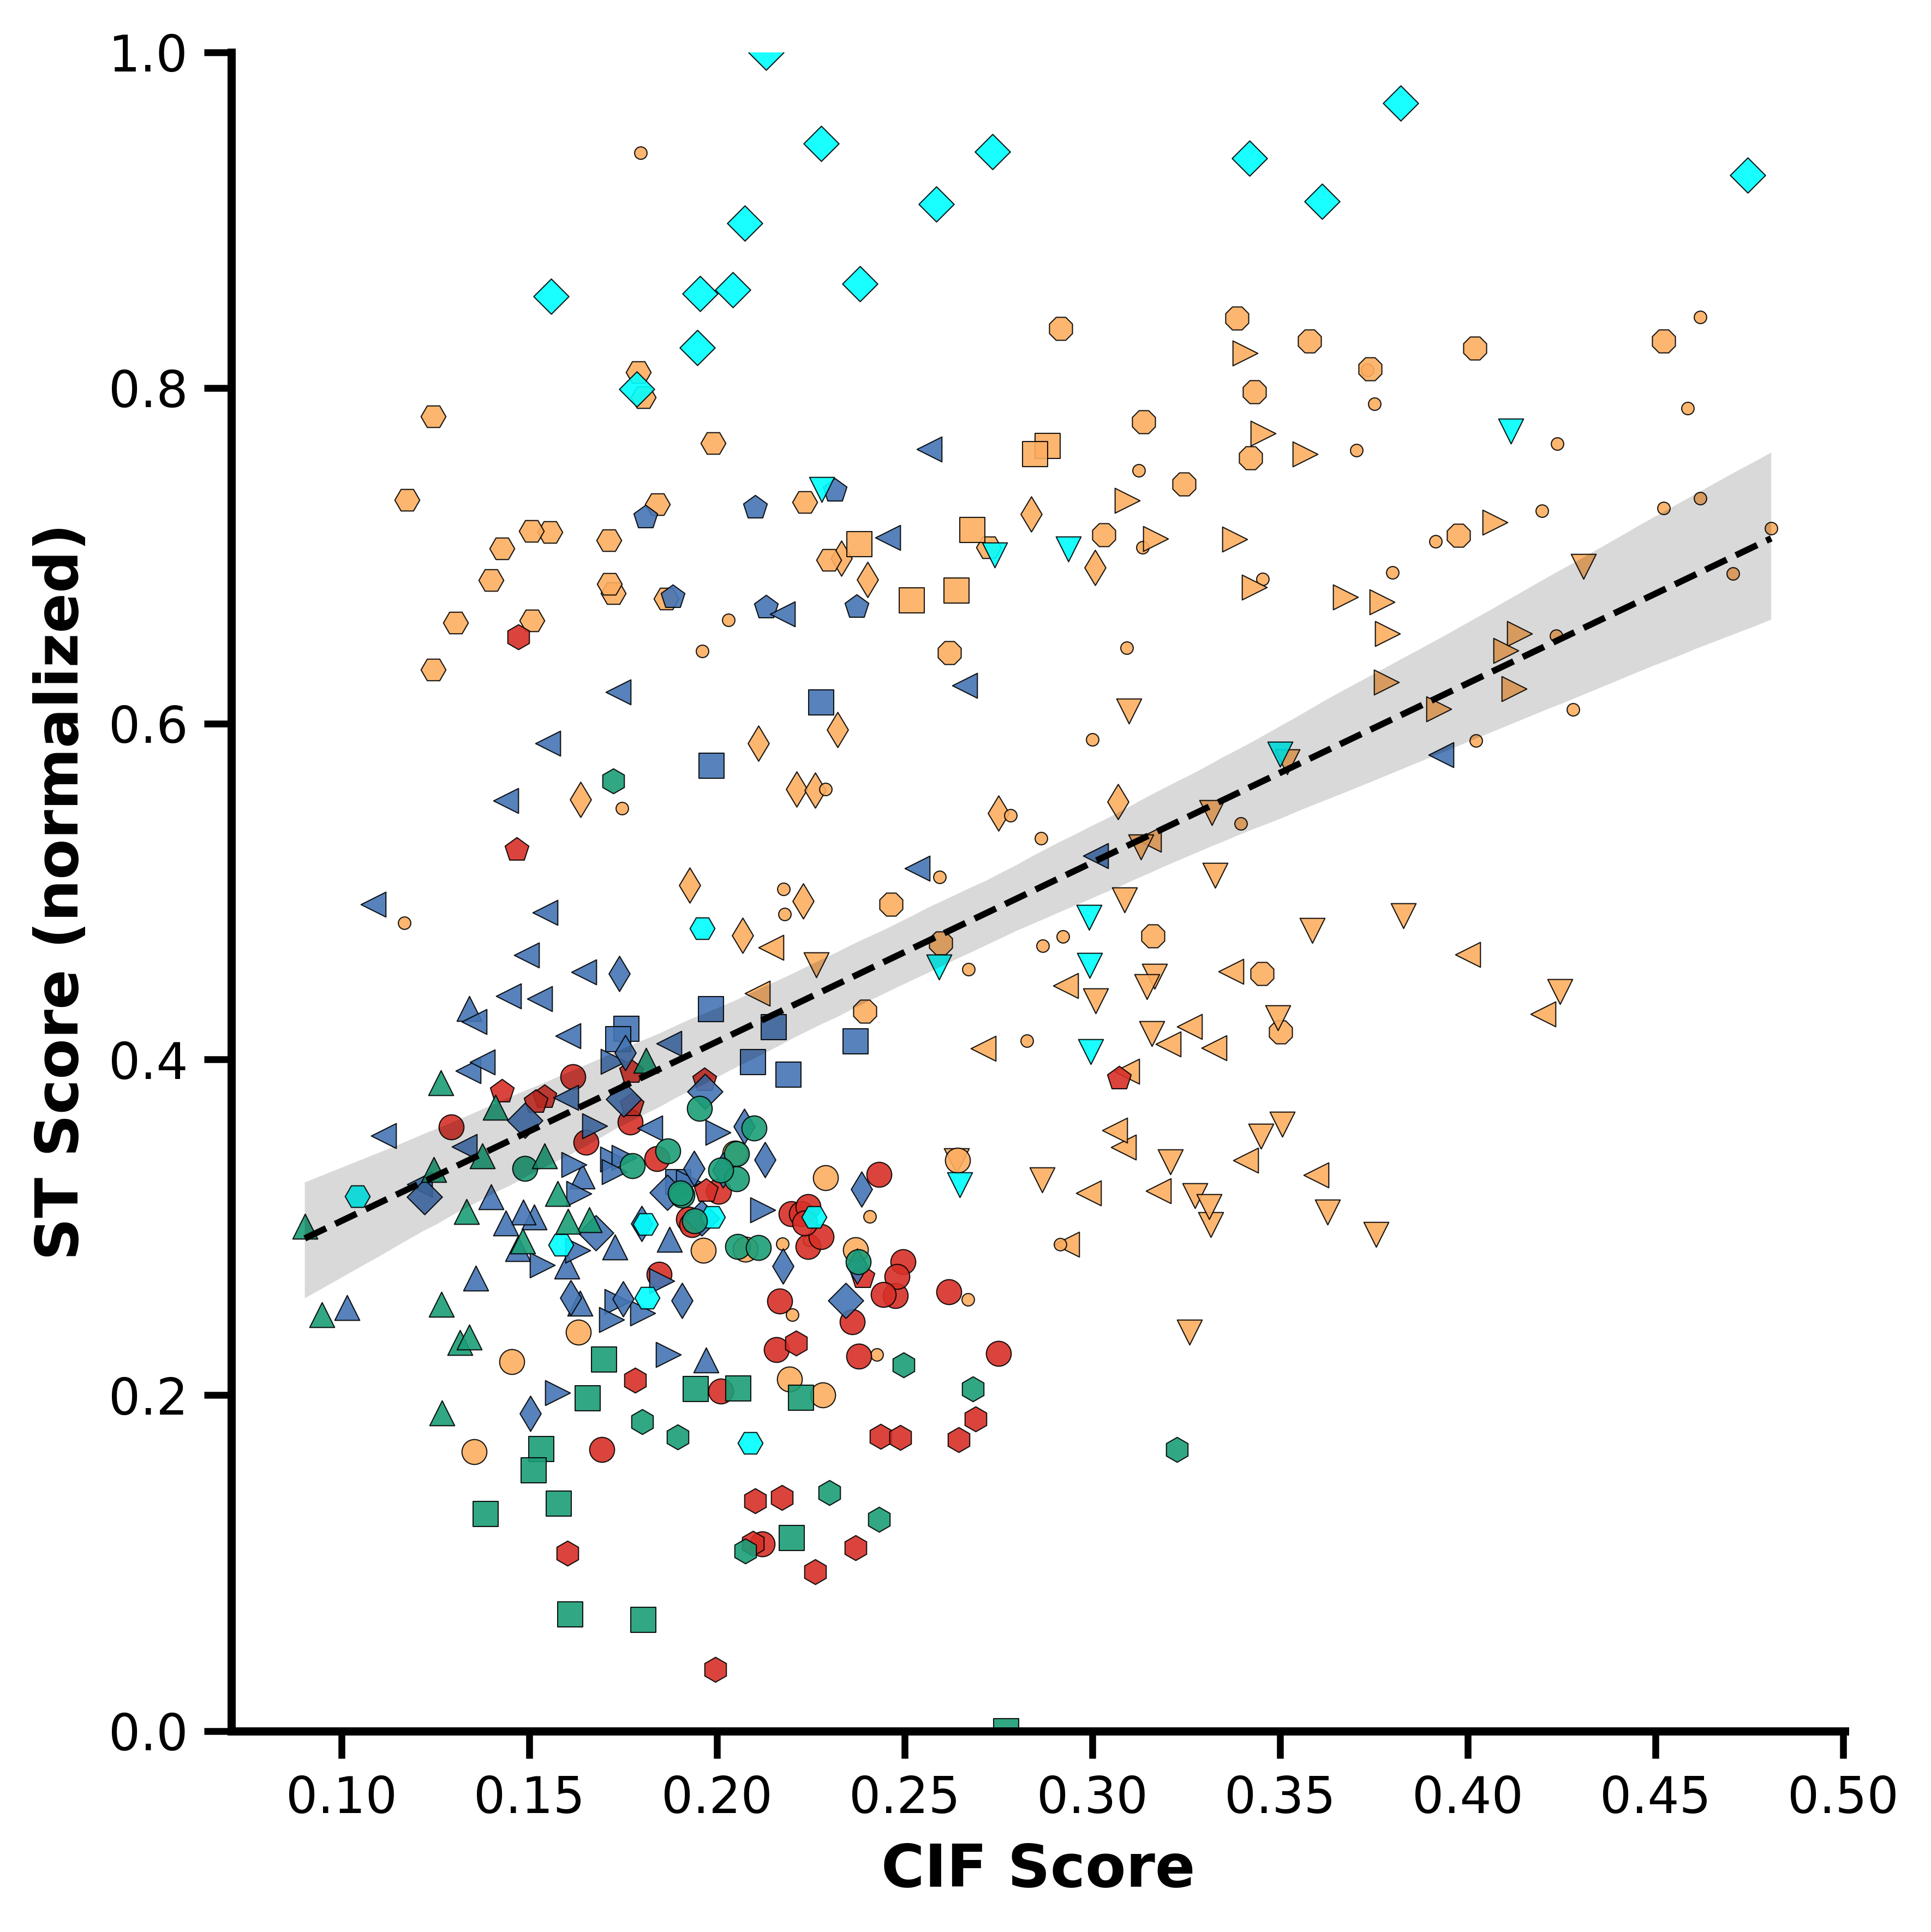

In [19]:
# Second plot more detailed
markers = ['.','o', 's', '^', 'v', '<', '>', '8', 'p', 'D', 'd', 'h', 'H']
unique_s = df[skey].astype(str).unique()
marker_map = {k: markers[i % len(markers)] for i, k in enumerate(unique_s)}

fig, ax = plt.subplots(figsize=(6, 6), dpi=600)

for dk in unique_d:
    color = palette[dk]
    sub_d = df[df[dkey].astype(str) == dk]
    for sk in sub_d[skey].astype(str).unique():
        sub = sub_d[sub_d[skey].astype(str) == sk]
        ax.scatter(
            sub[xcol],
            sub[ycol],
            color=color,
            marker=marker_map[sk],
            s=30,
            alpha=0.9,
            edgecolor='k',
            linewidth=0.25
        )

sns.regplot(
    data=df,
    x=xcol,
    y=ycol,
    scatter=False,
    color='black',
    line_kws={'linestyle': '--', 'linewidth': 1.4},
    ax=ax
)

ax.set_ylim(0, 1)
ax.set_xlabel("CIF Score", fontsize=13, weight='semibold')
ax.set_ylabel("ST Score (normalized)", fontsize=13, weight='semibold')

ax.tick_params(axis='both', which='major', width=1.5, length=6)
ax.tick_params(axis='both', which='minor', width=1.2, length=4)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(1.8)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)


sns.despine(top=True, right=True)
plt.tight_layout()
